In [40]:
import pandas as pd
import numpy as np
import json
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
data_dir = "data/"

pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

class Display:
    '''Helper class to display data and also save out json'''
    def __init__(self, data, orient="split", meta={}):
        '''orient options are: dict, list, split, records, index'''
        self.data = data
        self.orient = orient
        self.meta = meta
        
    def _repr_html_(self):
        try:
            return self.data.to_html()
        except Exception as e:
            return display(self.data)
    
    def _repr_json_(self):
        try:
            data = self.data.to_dict(orient=self.orient)
            if "index" in data:
                del(data["index"])
            return (data, self.meta)
        except Exception as e:
            return (json.dumps(self.data), self.meta)
    
    def __repr__(self):
        return str(self.data)
    
    def __str__(self):
        return str(self.data)
    
class Chart:
    '''Helper class to save out matplot chart data'''
    def __init__(self, data, kind, **kwargs):
        self.data = data
        self.kind = kind
        self.title = kwargs.get("title")
        self.chart = data.plot(kind=kind, **kwargs)
        self.meta = {"kind": kind}
        
    def _repr_json_(self):
        try:
            data = self.data.to_dict(orient="split")
        except Exception as e:
            data = json.dumps(self.data)
        data["chart"] = self.kind
        data["title"] = self.title
        return (data, self.meta)
    
class BigText:
    def __init__(self, line1, line2=None, colors=[]):
        self.line1 = line1
        self.line2 = line2
        self.colors = colors
        
    def _repr_json_(self):
        data = {"line1": self.line1, "line2": self.line2, "colors": self.colors}
        data["bigtext"] = True
        return data
    
    def _repr_html_(self):
        out = "<h3>{}</h3>".format(self.line1)
        if self.line2:
            out += "<h3>{}</h3>".format(self.line2)
        return out

## Citywide Payrolls

Here are the total salaries and overtime wages for all city agencies in 2019. The department of education is in the top spot, followed by the police.

[Source](https://data.cityofnewyork.us/City-Government/Citywide-Payroll-Data-Fiscal-Year-/k397-673e)

In [64]:
payroll = pd.read_csv("data/Citywide_Payroll_Data__Fiscal_Year_.csv", low_memory=False)
payroll_counts = pd.pivot_table(payroll[payroll["Fiscal Year"]==2019][['Agency Name', 'Base Salary', 'Regular Gross Paid', 'Total Other Pay', 'Total OT Paid']], index="Agency Name", aggfunc=np.sum).reset_index()
payroll_counts["Total"] = payroll_counts["Regular Gross Paid"] + payroll_counts["Total OT Paid"] + payroll_counts["Total Other Pay"]
payroll_counts = payroll_counts.sort_values(by="Total", ascending=False)
payroll_counts = payroll_counts.reindex(columns=['Agency Name', 'Base Salary', 'Regular Gross Paid', 'Total Other Pay', 'Total OT Paid', 'Total'])
payroll_counts.columns = ["Agency Name", "Base Salary $", "Regular Gross Paid $", "Other Pay $", "Overtime $", "Total"]
Display(payroll_counts)


,Agency Name,Base Salary $,Regular Gross Paid $,Other Pay $,Overtime $,Total
70,DEPT OF ED PEDAGOGICAL,"10,504,985,856.00","9,740,892,697.04","-1,249,127.08",0.00,"9,739,643,569.96"
126,POLICE DEPARTMENT,"4,109,923,694.94","3,895,716,912.50","538,739,298.94","727,903,579.28","5,162,359,790.72"
89,FIRE DEPARTMENT,"1,370,356,437.33","1,308,099,113.44","136,354,007.23","340,735,452.35","1,785,188,573.02"
69,DEPT OF ED PARA PROFESSIONALS,"1,178,122,166.62","1,195,740,690.03","188,956.85","2,260,994.20","1,198,190,641.08"
60,DEPARTMENT OF CORRECTION,"941,265,074.17","876,677,069.20","89,506,128.64","181,879,757.19","1,148,062,955.03"
65,DEPARTMENT OF SANITATION,"721,506,251.09","740,715,372.74","110,301,391.21","138,605,350.42","989,622,114.37"
61,DEPARTMENT OF EDUCATION ADMIN,"970,756,081.15","914,578,756.78","38,914,585.90","23,487,434.91","976,980,777.59"
92,HRA/DEPT OF SOCIAL SERVICES,"822,975,390.68","734,310,823.75","43,882,704.45","39,013,197.27","817,206,725.47"
115,NYC HOUSING AUTHORITY,"529,548,680.15","651,062,206.66","23,573,483.86","95,529,398.97","770,165,089.49"
73,DEPT OF ENVIRONMENT PROTECTION,"366,523,771.78","491,578,813.83","40,533,115.40","47,458,335.81","579,570,265.04"


Mysteriously, education employees received -$1,249,127.08 in "other" pay for 2019.

In [75]:
teacher_payroll = payroll[payroll["Agency Name"]=="DEPT OF ED PEDAGOGICAL"]
teacher_payroll = teacher_payroll[teacher_payroll["Fiscal Year"]==2019]
teacher_otherpay = teacher_payroll["Total Other Pay"].sum()
BigText(line1="Negative\nTeacher Payments:", line2="${:,.0f}".format(teacher_otherpay))

## Police Payroll Sorted by Total Overtime Paid, 2019 (rows 0-2000)

It's interesting to look at police payments, here sorted by individual total overtime paid out. Of particular note we see that one police officer doubled their salary through overtime pay. A top cop plumber also did particuarly well, bringing in $76K in OT.

In [23]:
cop_payroll = payroll[payroll["Agency Name"] == "POLICE DEPARTMENT"]
cop_payroll = cop_payroll[cop_payroll["Fiscal Year"] == 2019]
top_cops = cop_payroll[['Title Description', 'Base Salary', 'Regular Gross Paid', 'Total Other Pay', 'Total OT Paid']].sort_values(by="Total OT Paid", ascending=False)[0:2000]
top_cops.columns = ["Job Title", "Base Salary $", "Regular Gross Paid $", "Other Pay $", "Overtime $"]
Display(top_cops)

,Job Title,Base Salary $,Regular Gross Paid $,Other Pay $,Overtime $
3313649,POLICE OFFICER D/A DETECTIVE 2ND GR,"109,360.00","107,524.64","20,979.07","103,091.60"
3284392,STATIONARY ENGINEER,486.72,"126,547.20","17,963.45","101,740.00"
3328794,STATIONARY ENGINEER,486.72,"126,547.20","34,802.95","100,332.68"
3305370,STATIONARY ENGINEER,486.72,"126,547.20","13,962.23","87,938.10"
3315423,STATIONARY ENGINEER,486.72,"126,547.20","32,732.04","84,850.46"
3282816,STATIONARY ENGINEER,486.72,"126,547.20","36,211.70","84,292.44"
3320054,POLICE OFFICER D/A DETECTIVE 1ST GR,"125,531.00","123,424.25","27,377.49","81,205.25"
3287950,SENIOR STATIONARY ENGINEER,577.68,"150,196.80",0.00,"77,941.73"
3280324,SUPERVISOR PLUMBER,387.03,"101,270.05",0.00,"76,366.22"
3285628,SENIOR STATIONARY ENGINEER,577.68,"150,196.80","1,606.68","76,262.94"


Here's a quick summary of police payroll:

In [24]:
total_dollars = cop_payroll["Regular Gross Paid"].sum() + cop_payroll["Total Other Pay"].sum() + cop_payroll["Total OT Paid"].sum()
cop_payroll_totals = pd.DataFrame([
    {"Type": "Base", "Amount": cop_payroll["Base Salary"].sum()},
    {"Type": "Gross", "Amount": cop_payroll["Regular Gross Paid"].sum()},
    {"Type": "Other", "Amount": cop_payroll["Total Other Pay"].sum()},
    {"Type": "Overtime Hours", "Amount": cop_payroll["OT Hours"].sum()},
    {"Type": "Overtime Paid", "Amount": cop_payroll["Total OT Paid"].sum()},
    {"Type": "Total", "Amount": total_dollars},
])
Display(cop_payroll_totals)

,Type,Amount
0,Base,"4,109,923,694.94"
1,Gross,"3,895,716,912.50"
2,Other,"538,739,298.94"
3,Overtime Hours,"11,597,478.13"
4,Overtime Paid,"727,903,579.28"
5,Total,"5,162,359,790.72"


...

In [73]:
BigText(line1="Cop Overtime:", line2="${:,.0f}".format(cop_payroll["Total OT Paid"].sum()))

Let's look at a breakdown of all the NYPD jobs. Here are all NYPD jobs, sorted by total amount paid out in 2019. Police Officers make up the bulk of the payroll budget.

In [90]:
cop_jobs = cop_payroll[['Title Description', 'Base Salary', 'Regular Gross Paid', 'Total Other Pay', 'Total OT Paid']]
cop_jobs["Total"] = cop_jobs["Regular Gross Paid"] + cop_jobs["Total Other Pay"] + cop_jobs["Total OT Paid"]
cop_jobs = cop_jobs.reindex(columns=['Title Description', 'Total'])

#top_cops.columns = ["Job Title", "Base Salary $", "Regular Gross Paid $", "Other Pay $", "Overtime $"]
cop_jobs = pd.pivot_table(cop_jobs, index="Title Description", aggfunc=np.sum).sort_values(by="Total", ascending=False).reset_index()
cop_jobs.columns = ["Job Title", "Total Paid $"]
Display(cop_jobs)

/Users/sam/projects/police-data/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Job Title,Total Paid $
0,POLICE OFFICER,"2,199,729,407.45"
1,SERGEANT-,"565,739,069.42"
2,P.O. DA DET GR3,"471,027,705.50"
3,SCHOOL SAFETY AGENT,"273,097,629.46"
4,LIEUTENANT,"237,615,083.86"
5,POLICE OFFICER D/A DETECTIVE 2ND GR,"141,410,201.22"
6,P.O. DET SPEC,"134,912,905.26"
7,TRAFFIC ENFORCEMENT AGENT AL 1 & 2 ONLY,"131,619,212.27"
8,POLICE OFFICER D/A DETECTIVE 1ST GR,"72,792,274.27"
9,POLICE COMMUNICATIONS TECHNICIAN,"72,456,680.49"


In [ ]:
School safety officers were paid $273,097,629 in 2019.

In [110]:
school_cop_payroll_total = cop_jobs[cop_jobs['Job Title'].str.match('SCHOOL SAFETY AGENT')].iat[0,1]
school_cop_total = len(cop_payroll[cop_payroll['Title Description'].str.match('SCHOOL SAFETY AGENT')])
BigText(line1="{} Cops at School for".format(school_cop_total), line2="${:,.0f}".format(school_cop_payroll_total))

## Arrests in 2019

Here we examine data about arrests in New York from 2019, [provided by the NYPD](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u).

Police provide a series of increasingly specific categorization for arrests. Most broadly they are labelled "Misdemeanors" (considered to be minor crimes), "Felonys" (considered to be more serious crimes), "Violations" and finally "I", which is not defined in the data dictionary provided.

The majority of arrests are for misdemeanors.

In [25]:
arrest_data = pd.read_csv("data/NYPD_Arrests_Data__Historic_.csv")
arrests_2019 = arrest_data[arrest_data['ARREST_DATE'].str.contains('2019')]

arrest_cats = pd.DataFrame(arrests_2019['LAW_CAT_CD'].value_counts())
arrest_cats.rename(index = {"M": "Misdemeanor", "F":"Felony", "V": "Violation"}, inplace=True)
Display(arrest_cats)

,LAW_CAT_CD
Misdemeanor,126609
Felony,83384
Violation,2822
I,433


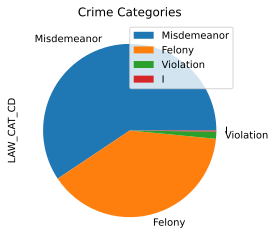

In [26]:
Chart(arrest_cats, kind='pie', y=0, title="Crime Categories")

### Cost of Arrests

Let's consider the human labor cost associated with arrests. 

The total amount paid out to NY cops and cop administrators in 2019 was `$5,162,359,790.72`.

There were 21,4617 arrests that year. Dividing total $$ by total arrests, we can see that the cost of a single arrest in cop payroll is `$24,053`.

In [79]:
total_arrests = len(arrests_2019)
human_dollars_per_arrest = total_dollars / total_arrests
BigText(line1="Cost Per\nArrest:", line2="${:,.0f}".format(human_dollars_per_arrest))

### Crimes

The police provide a general category of each type of arrest. Here are the totals for 2019.

1. The lowest-level theft offense in New York is called "petit larceny," or petty theft, which is the unlawful taking of property or services valued at no more than `$1,000`.

2. Given that arrest costs around 24,000 in person hours, the total cost for all petty theft arrests comes to `$519,048,000`. Let's say that each petit theft was in fact for the maximum `$1000`, meaning the total value of goods stolen is `$21,627,000`. This means that if the city simply reimbursed for lost property instead of arresting people it would save New York `$497,421,000`.

3. "ASSAULT 3" is assault in the 3rd degree: "Assault in the third degree is the top charge when there are only minor injuries, weapons are not used, and the victim does not fall into a special protected category" (SCUFFLES)

4. "Escape 3" is "escape in the third degree", or when a person escapes from custody.

5. I am confused about "OFFENSES AGAINST PUBLIC ADMINI" - it seems to encompass a ton of stuff.

6. "Theft of services" (4194 arrests) can include riding public transit without a pass.

7. "Dangerous Drugs" represents all drug use, including marijuana.

In [28]:
arrest_counts = pd.DataFrame(arrests_2019['OFNS_DESC'].value_counts()).reset_index()
arrest_counts.columns = ["Offense Type", "Total Arrests"]
Display(arrest_counts)

,Offense Type,Total Arrests
0,ASSAULT 3 & RELATED OFFENSES,31988
1,PETIT LARCENY,21627
2,DANGEROUS DRUGS,21071
3,FELONY ASSAULT,15208
4,VEHICLE AND TRAFFIC LAWS,14243
5,MISCELLANEOUS PENAL LAW,12325
6,CRIMINAL MISCHIEF & RELATED OF,9971
7,GRAND LARCENY,9913
8,ROBBERY,9259
9,DANGEROUS WEAPONS,7921


## Complaint Data

The police also provide data about criminal complaints. These are calls that people make to 911 that may or may not lead to arrests.

[Source](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i)

### Attempted vs Completed Crimes

One interesting column in the complaint data is "CRM_ATPT_CPTD_CD", which indicates "whether crime was successfully completed or attempted, but failed or was interrupted prematurely".

Using this data we can see the total number of crimes that the police were potentially able to stop.

It's less than 2%.

In [29]:
# load historical complaint data
complaint_data = pd.read_csv(data_dir + "NYPD_Complaint_Data_Historic.csv", low_memory=False)
completed_crime_counts = pd.DataFrame(complaint_data["CRM_ATPT_CPTD_CD"].value_counts()).reset_index()
completed_crime_counts.columns = ["Crime Status", "Total"]
Display(completed_crime_counts)

,Crime Status,Total
0,COMPLETED,7184747
1,ATTEMPTED,124901


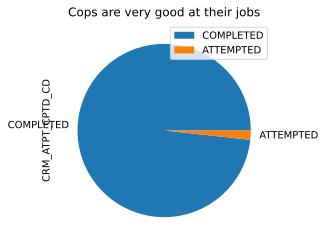

In [30]:
Chart(pd.DataFrame(complaint_data["CRM_ATPT_CPTD_CD"].value_counts()), kind='pie', y=0, title="Cops are very good at their jobs")

The police also have an interesting method of marking the gender of victims.

In [31]:
victim_sex = pd.DataFrame(complaint_data["VIC_SEX"].value_counts())
victim_sex.rename(index = {"U": "Unknown", "F": "Female", "M":"Male", "E": "People of the State of New York", "D": "Business/Organization"}, inplace=True)
victim_sex

,VIC_SEX
Female,2861342
Male,2403381
People of the State of New York,1156585
Business/Organization,888036
Unknown,4


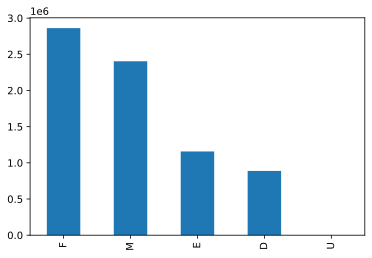

In [32]:
complaint_data["VIC_SEX"].value_counts().plot(kind='bar')

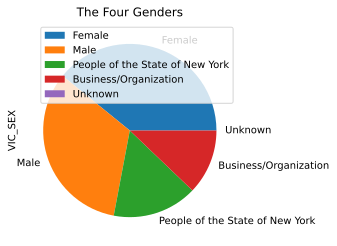

In [33]:
Chart(victim_sex, kind='pie', y=0, title="The Four Genders")

Not all of these genders seem to appear in the "suspect gender" columns. Notably, the "business" gender is absent. 

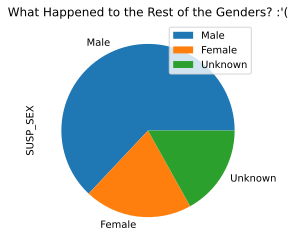

In [34]:
suspect_sex = pd.DataFrame(complaint_data["SUSP_SEX"].value_counts())
suspect_sex
suspect_sex.rename(index = {"U": "Unknown", "F": "Female", "M":"Male"}, inplace=True)

Chart(suspect_sex, kind='pie', y=0, title="What Happened to the Rest of the Genders? :'(")

In [80]:
%run ./reformat_notebook.py